# Classifying Potential Pneumonia Cases using Convolutional Neural Network (CNN)

**Author: Achyut Kafle**

**Background**

Accurate diagnosis of pneumonia requires review of chest radiographs for visual signal of lung opacities by highly trained medical professionals. This visual clue is then complemented by information from clinical history and other laboratory exams to confirm the disease. Identifying the increased area of lung opacities in the chest radiographs is complicated by other conditions in the lungs such as bleeding, fluid overload, lung cancer, surgical changes, etc. Deep learning model such as a convolutional neural network (CNN) could be used to automatically locate lung opacities in the chest radiographs to detect visual signal for pneumonia. 

**Objective**

In this project, I build and train a simple CNN model to classify pneumonia cases using chest radiographs and evaluate its performance using the validation and test images. 


**Data**

For training the CNN model, I use the chest radiographs from __[this kaggle competition](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)__. I use random sampling to retrieve train, validation and test radiographs that my machine can handle. Here are the steps I took:

* There are 26,684 unique chest radigraphs available from the competition. Of those radiographs, 22.53% are identified as pneumonia cases. I use random under sampling of the majority class (i.e., normal cases) to gather balanced samples of about 12,024 radiographs.

* I then randomly sample about 8% (998 radiographs) of the balanced samples (12,024) and save them as test samples. 

* Of the reamining 11,026 samples, I randomly sample about 9% (1,004) and save them as validation images. 

* Of the remaining 10,022, I randomly sample 50% (5,011) and save them as my train samples.

All provided images are in DICOM format and I converted them to .jpg images after I complete sampling process as described above. For this analysis, I resize the original 1024x1024x3 images to 150x150x3. 

**Takeaways from this analysis**

* A realtively simple CNN architecture achieved a resonable performance (accuracy: 75%; recall (pneumonia class): 0.82 in this case). 

* I evaluated three different optimizers- Adam, SGD and RMSprop. All of them performed very consistently on accuracy metric except SGD terminated at early epochs.

* I also evaluated these optimizers at different batch sizes- 100, 200, and 400. There does not seem to be a huge improvement on performance by larger batche sizes in this case. Compared to what time it takes to train the model, it may not be worth using the largest batch size i.e., 400 in this case.

* I also used a simple feature-wise centering and normalization image pre-processing technique before feeding those train images into the model. In this case, pre-processing improved performance a little bit (~76%). 

* Finally, I used a pre-trained VGG16 model weights for my classification task. The pre-trained model did not work well in this case.  

In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
import glob

import imageio
from skimage.transform import resize
import pydicom

from sklearn.metrics import classification_report, confusion_matrix
from time import time
import warnings

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten 
from keras.optimizers import RMSprop, Adam, SGD
from keras import metrics

Using TensorFlow backend.
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


# 1. Prepare train images

In [2]:
# Specify the folder and image paths
abs_path=os.path.abspath(os.path.join('..'))
train_images_folder = os.path.join(abs_path, 'data', 'train_images')
train_images_path = glob.glob(os.path.join(train_images_folder, '*.jpg'))
train_images_path[0:5]

['/Users/achyutkafle/Desktop/Thinkful/data/train_images/f93d9a23-cc0d-4eff-abf1-62139ebe80d9.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/train_images/3abb7176-035d-46cc-844e-820870e8154b.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/train_images/55d5fe58-1dd5-454e-8628-92ef7f2993dc.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/train_images/da358a05-8106-45af-9a65-a95e5296cc09.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/train_images/e46bf3ce-4426-4f41-bcf5-4afb112164b5.jpg']

In [3]:
# Load train images original sizes (1024x1024x3)
train_images = [imageio.imread(image, pilmode='RGB') for image in train_images_path]

In [4]:
# Disable harmless update warnings
warnings.filterwarnings("ignore")

# Resize train images (150x150x3)
resized = [resize(i, (150, 150), anti_aliasing=True) for i in train_images]
rs_train_images = np.array(resized)

# Resized train images shape
print ('Resized train images shape: ', rs_train_images.shape)

Resized train images shape:  (5011, 150, 150, 3)


In [5]:
# Convert target labels to numpy array 
df_train=pd.read_csv('~/Desktop/Thinkful/data/df_train.csv')

# Convert Target into numpy array
y_train=np.array(df_train['Target'])
df_train.head(5)

,patientId,0,index,x,y,width,height,Target
0,f93d9a23-cc0d-4eff-abf1-62139ebe80d9,28113,28113,NaN,NaN,NaN,NaN,0
1,3abb7176-035d-46cc-844e-820870e8154b,3803,3803,138.0,305.0,242.0,529.0,1
2,55d5fe58-1dd5-454e-8628-92ef7f2993dc,7297,7297,693.0,385.0,135.0,132.0,1
3,da358a05-8106-45af-9a65-a95e5296cc09,24288,24288,NaN,NaN,NaN,NaN,0
4,e46bf3ce-4426-4f41-bcf5-4afb112164b5,25497,25497,NaN,NaN,NaN,NaN,0


# 2. Prepare validation images

In [6]:
# Specify the folder and image paths
valid_images_folder = os.path.join(abs_path, 'data', 'valid_images')
valid_images_path = glob.glob(os.path.join(valid_images_folder, '*.jpg'))
valid_images_path[0:5]

['/Users/achyutkafle/Desktop/Thinkful/data/valid_images/af8a9a3f-9487-454b-8ee6-65c9554f3a87.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/valid_images/f7793f41-fe23-4e09-8bef-6394b56bed37.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/valid_images/6ed56555-277d-42bc-9e16-c43b679b62d2.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/valid_images/9b90c3f5-5126-4ef4-b109-244c88676697.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/valid_images/17bbf318-ef96-4dac-99e0-59fae5c60b56.jpg']

In [7]:
# Load validation images original sizes (1024x1024x3)
valid_images = [imageio.imread(image, pilmode='RGB') for image in valid_images_path]

In [8]:
# Resize validation images (150x150x3)
resized = [resize(i, (150, 150), anti_aliasing=True) for i in valid_images]
rs_valid_images = np.array(resized)

# Resized image shape
print ('Resized validation images shape: ', rs_valid_images.shape)

Resized validation images shape:  (1004, 150, 150, 3)


In [9]:
# Convert target labels to numpy array 
df_valid=pd.read_csv('~/Desktop/Thinkful/data/df_valid.csv')

# Convert Target into numpy array
y_valid=np.array(df_valid['Target'])
df_valid.head(5)

,patientId,0,index,x,y,width,height,Target
0,af8a9a3f-9487-454b-8ee6-65c9554f3a87,18667,18667,294.0,606.0,132.0,120.0,1
1,f7793f41-fe23-4e09-8bef-6394b56bed37,27898,27898,630.0,188.0,221.0,506.0,1
2,6ed56555-277d-42bc-9e16-c43b679b62d2,10400,10400,NaN,NaN,NaN,NaN,0
3,9b90c3f5-5126-4ef4-b109-244c88676697,16036,16036,555.0,367.0,270.0,574.0,1
4,17bbf318-ef96-4dac-99e0-59fae5c60b56,1646,1646,NaN,NaN,NaN,NaN,0


# 3. Prepare test images

In [10]:
# Specify the folder and image paths
test_images_folder = os.path.join(abs_path, 'data', 'test_images')
test_images_path = glob.glob(os.path.join(test_images_folder, '*.jpg'))
test_images_path[0:5]

['/Users/achyutkafle/Desktop/Thinkful/data/test_images/07332989-6518-4bd9-96de-f4513948cf4a.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/test_images/e380d5fb-dc74-41c9-adad-05b7b88b9137.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/test_images/75dbc949-4634-4f9c-b3bb-a8c03747e9e1.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/test_images/3c0a97d7-6d90-46a6-a10a-1df9e4064d52.jpg',
 '/Users/achyutkafle/Desktop/Thinkful/data/test_images/8ca19865-fd6c-4bcd-a2a0-7f9e9ea4bc5c.jpg']

In [11]:
# Load test images original sizes (1024x1024x3)
test_images = [imageio.imread(image, pilmode='RGB') for image in test_images_path]

In [12]:
# Resize test images (150x150x3)
resized = [resize(i, (150, 150), anti_aliasing=True) for i in test_images]
rs_test_images = np.array(resized)

# Resized image shape
print ('Resized test images shape: ', rs_test_images.shape)

Resized test images shape:  (998, 150, 150, 3)


In [13]:
# Convert target labels to numpy array 
df_test=pd.read_csv('~/Desktop/Thinkful/data/df_test.csv')

# Convert Target into numpy array
y_test=np.array(df_test['Target'])

df_test.head(5)

,patientId,0,index,x,y,width,height,Target
0,07332989-6518-4bd9-96de-f4513948cf4a,379,379,146.0,701.0,303.0,323.0,1
1,e380d5fb-dc74-41c9-adad-05b7b88b9137,25388,25388,162.0,412.0,228.0,260.0,1
2,75dbc949-4634-4f9c-b3bb-a8c03747e9e1,11313,11313,720.0,363.0,166.0,308.0,1
3,3c0a97d7-6d90-46a6-a10a-1df9e4064d52,3997,3997,608.0,360.0,292.0,233.0,1
4,8ca19865-fd6c-4bcd-a2a0-7f9e9ea4bc5c,14158,14158,580.0,228.0,301.0,614.0,1


# 4. Conduct exploratory data analysis

In [14]:
# Concat train, validation and test samples for exploratory data analysis
df=pd.concat([df_train, df_valid, df_test])
df.head()

,patientId,0,index,x,y,width,height,Target
0,f93d9a23-cc0d-4eff-abf1-62139ebe80d9,28113,28113,NaN,NaN,NaN,NaN,0
1,3abb7176-035d-46cc-844e-820870e8154b,3803,3803,138.0,305.0,242.0,529.0,1
2,55d5fe58-1dd5-454e-8628-92ef7f2993dc,7297,7297,693.0,385.0,135.0,132.0,1
3,da358a05-8106-45af-9a65-a95e5296cc09,24288,24288,NaN,NaN,NaN,NaN,0
4,e46bf3ce-4426-4f41-bcf5-4afb112164b5,25497,25497,NaN,NaN,NaN,NaN,0


Text(0,0.5,'Count')

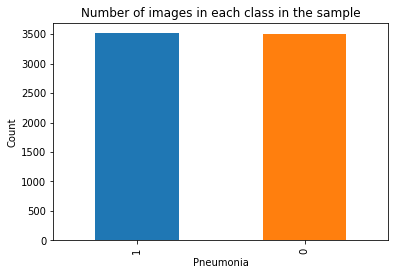

In [15]:
# Plot classes 
df['Target']. value_counts().plot. bar()
plt.title('Number of images in each class in the sample')
plt.xlabel('Pneumonia')
plt.ylabel('Count')

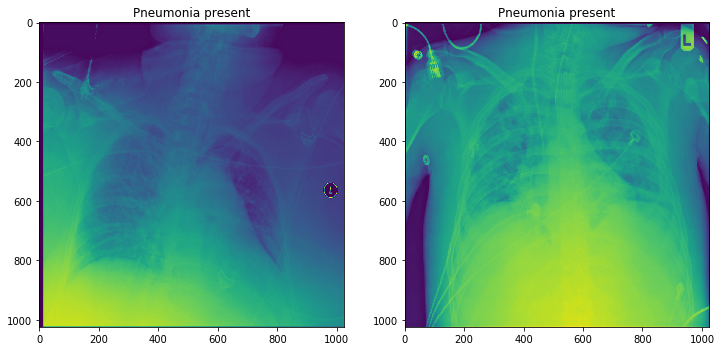

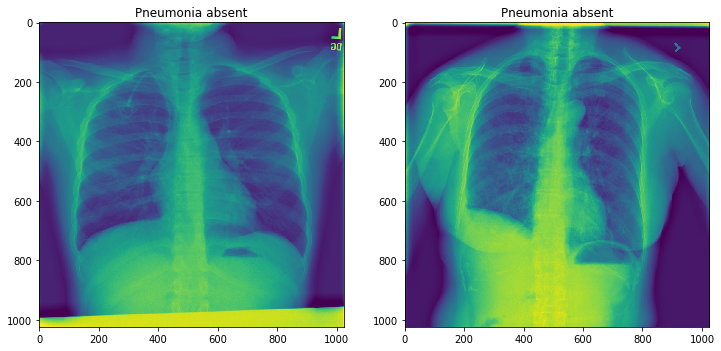

In [16]:
# View example images
pneum_1 = '/Users/achyutkafle/Desktop/Thinkful/data/stage_2_train_images/3abb7176-035d-46cc-844e-820870e8154b.dcm'
pneum_2 = '/Users/achyutkafle/Desktop/Thinkful/data/stage_2_train_images/55d5fe58-1dd5-454e-8628-92ef7f2993dc.dcm'
not_1 = '/Users/achyutkafle/Desktop/Thinkful/data/stage_2_train_images/f93d9a23-cc0d-4eff-abf1-62139ebe80d9.dcm'
not_2 = '/Users/achyutkafle/Desktop/Thinkful/data/stage_2_train_images/da358a05-8106-45af-9a65-a95e5296cc09.dcm'

plt.figure(figsize=(12,12))

# Images with pneumonia presence 
plt.subplot(1,2,1)
img1 = pydicom.dcmread(pneum_1)
plt.imshow(img1.pixel_array)
plt.title('Pneumonia present')

plt.subplot(1,2,2)
img2 = pydicom.dcmread(pneum_2)
plt.imshow(img2.pixel_array)
plt.title('Pneumonia present')
plt.show()

# Images with pneumonia absence
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
img3 = pydicom.dcmread(not_1)
plt.imshow(img3.pixel_array)
plt.title('Pneumonia absent')

plt.subplot(1,2,2)
img4 = pydicom.dcmread(not_2)
plt.imshow(img4.pixel_array)
plt.title('Pneumonia absent')
plt.show()

In [17]:
# Calcualte centers of x and y values using width and height respectively
df['x_center']=df['x'] + df['width']/2
df['y_center']=df['y'] + df['height']/2

Text(0.5,0.98,'Pneumonia location')

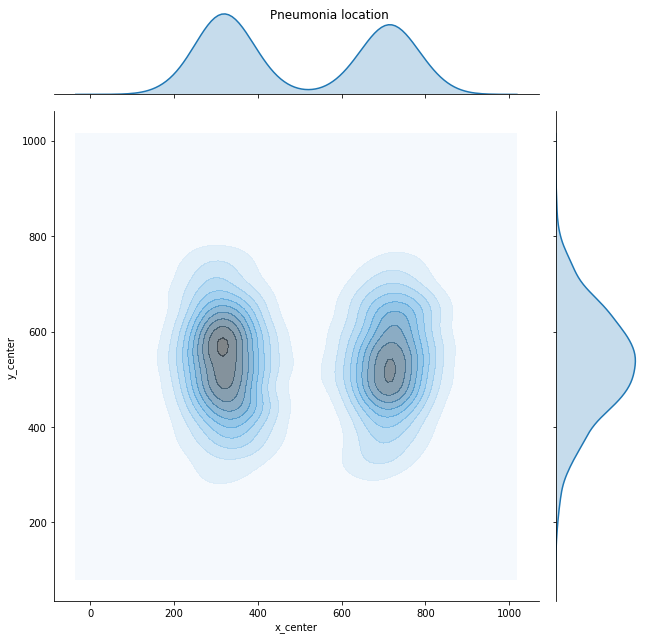

In [18]:
# Plot x and y centers
sns.jointplot("x_center", "y_center",kind="kde", data=df, height=9, alpha=0.5)
plt.suptitle('Pneumonia location')

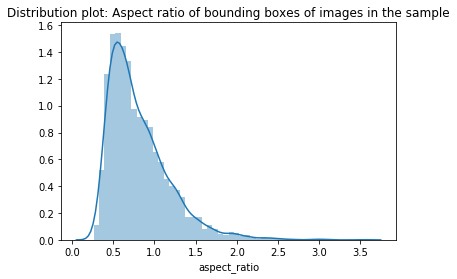

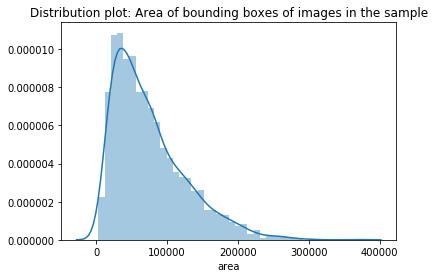

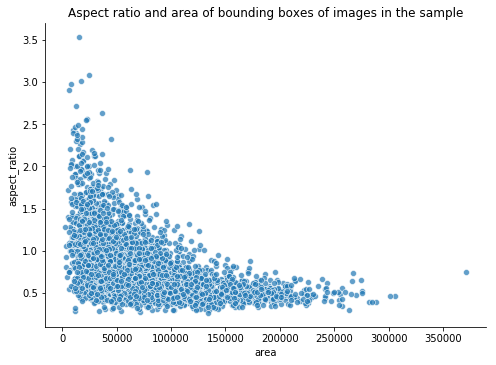

In [19]:
# Aspect ratio of bounding boxes in the sample
df['aspect_ratio'] = df['width']/df['height']
sns.distplot(df['aspect_ratio'].dropna(), norm_hist=True)
plt.title('Distribution plot: Aspect ratio of bounding boxes of images in the sample')
plt.show()

# Area of bounding boxes in the sample
df['area'] = df['width']* df['height']
sns.distplot(df['area'].dropna(), norm_hist=True)
plt.title('Distribution plot: Area of bounding boxes of images in the sample')
plt.show()

# Relationship between aspect ratio and area of bounding boxes of images in the sample
sns.relplot(x='area', y='aspect_ratio', data=df, height=5, alpha=0.7, aspect=1.4)
plt.title('Aspect ratio and area of bounding boxes of images in the sample')
plt.show()

# 5. Prepare numpy array data for deep learning

In [20]:
# Scale 
x_train = rs_train_images / 255
x_valid = rs_valid_images / 255
x_test = rs_test_images / 255

# Save as float32
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

# Sample shapes
print(x_train.shape[0], 'train images')
print(x_valid.shape[0], 'validation images')
print(x_test.shape[0], 'test images')

5011 train images
1004 validation images
998 test images


In [21]:
# Convert Target to categorical
y_trainCat = to_categorical(y_train, num_classes = 2)
y_validCat = to_categorical(y_valid, num_classes = 2)
y_testCat = to_categorical(y_test, num_classes = 2)

# 6. Build a base CNN

In [22]:
# Build a model
model = Sequential()

# Add the first convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(150,150,3)))

# Add the first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Add the second convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add the second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the matrix into vector
model.add(Flatten())

# Add a dense (or fully connected) layer
model.add(Dense(1000, activation='relu'))

# Add output layer
model.add(Dense(2, activation='softmax'))

In [23]:
# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              82945000  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2002      
Total para

In [24]:
# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

In [25]:
# Define a helper function to fit and evaluate the cnn model
def fit_evaluate_cnn(BatchSize):
    model_history=model.fit(x_train,y_trainCat, epochs=50, batch_size=BatchSize, validation_data=(x_valid,y_validCat),
                            verbose=1, callbacks=[early_stopping, reduce_lr])
    #Plot accuracy
    sns.set(style="darkgrid")
    fig = plt.figure(figsize=(7,6))
    plt.plot(model_history.history['acc']) # Train accuracy
    plt.plot(model_history.history['val_acc']) # Validation accuracy
    plt.title('Model accuracy across epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.5, 0.8)
    plt.xlim(0, 50)
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    # Plot loss
    sns.set(style="darkgrid")
    fig = plt.figure(figsize=(7,6))
    plt.plot(model_history.history['loss']) # Train loss 
    plt.plot(model_history.history['val_loss']) # Validation loss
    plt.title('Model loss across epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0.5, 0.8)
    plt.xlim(0, 50)
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    print('Model performance on the test images')
    
    # Make prediction on the test images
    test_score = model.evaluate(x_test, y_testCat, verbose=0)
    
    # Accuracy and loss on the test samples 
    print('Loss: ', test_score[0])
    print('Accuracy: ', test_score[1])
    print('\n')
    
    # Classification report
    test_pred=model.predict(x_test)
    test_pred=np.round(test_pred)
    print('Clasification report')
    print(classification_report(y_testCat, test_pred))
    
    # Predictions on the test images
    prediction = model.predict(x_test, verbose=0)
    
    # Collect prediction on a list
    y_pred = []
    
    # Append the index of the larger value to the list
    for i in prediction:
        y_pred.append(list(i).index(max(i)))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 7. Fit the CNN using Adam optimizer at 100, 200 and 400 batch sizes

In [26]:
# Start time
start=time()

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 321s 64ms/step - loss: 0.6921 - acc: 0.5462 - val_loss: 0.6906 - val_acc: 0.6733
Epoch 2/50
5011/5011 [==============================] - 290s 58ms/step - loss: 0.6883 - acc: 0.6681 - val_loss: 0.6849 - val_acc: 0.7052
Epoch 3/50
5011/5011 [==============================] - 278s 56ms/step - loss: 0.6811 - acc: 0.6869 - val_loss: 0.6745 - val_acc: 0.6723
Epoch 4/50
5011/5011 [==============================] - 283s 56ms/step - loss: 0.6695 - acc: 0.6707 - val_loss: 0.6601 - val_acc: 0.7072
Epoch 5/50
5011/5011 [==============================] - 287s 57ms/step - loss: 0.6523 - acc: 0.6979 - val_loss: 0.6421 - val_acc: 0.7012
Epoch 6/50
5011/5011 [==============================] - 281s 56ms/step - loss: 0.6331 - acc: 0.6983 - val_loss: 0.6235 - val_acc: 0.7032
Epoch 7/50
5011/5011 [==============================] - 297s 59ms/step - loss: 0.6152 - acc: 0.7021 - val_loss: 0.6062 - val_acc: 

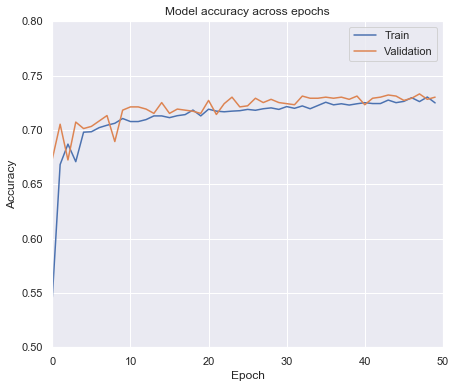

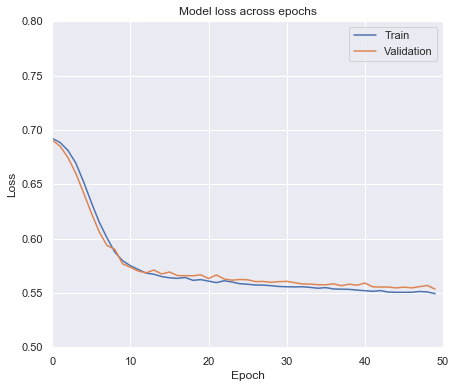

Model performance on the test images
Loss:  0.5491940477090274
Accuracy:  0.74448897807536


Clasification report
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       498
          1       0.74      0.75      0.75       500

avg / total       0.74      0.74      0.74       998



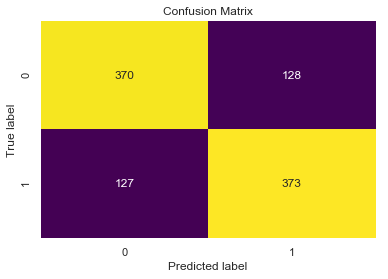

In [27]:
# Fit CNN with Adam optimizer and 100 batches
model.compile(keras.optimizers.Adam(lr=1e-5), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
fit_evaluate_cnn(100)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 241s 48ms/step - loss: 0.5499 - acc: 0.7282 - val_loss: 0.5543 - val_acc: 0.7321
Epoch 2/50
5011/5011 [==============================] - 234s 47ms/step - loss: 0.5530 - acc: 0.7218 - val_loss: 0.5542 - val_acc: 0.7301
Epoch 3/50
5011/5011 [==============================] - 231s 46ms/step - loss: 0.5486 - acc: 0.7272 - val_loss: 0.5559 - val_acc: 0.7341
Epoch 4/50
5011/5011 [==============================] - 230s 46ms/step - loss: 0.5485 - acc: 0.7280 - val_loss: 0.5546 - val_acc: 0.7281
Epoch 5/50
5011/5011 [==============================] - 229s 46ms/step - loss: 0.5495 - acc: 0.7282 - val_loss: 0.5539 - val_acc: 0.7311
Epoch 6/50
5011/5011 [==============================] - 227s 45ms/step - loss: 0.5480 - acc: 0.7268 - val_loss: 0.5530 - val_acc: 0.7261
Epoch 7/50
5011/5011 [==============================] - 229s 46ms/step - loss: 0.5483 - acc: 0.7288 - val_loss: 0.5545 - val_acc: 

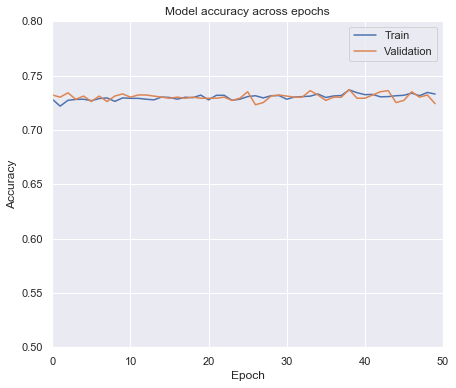

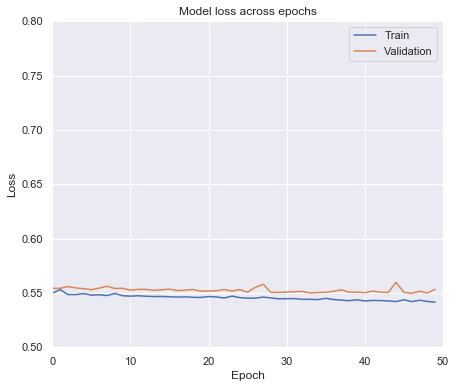

Model performance on the test images
Loss:  0.5463660248295816
Accuracy:  0.7464929859719439


Clasification report
             precision    recall  f1-score   support

          0       0.77      0.70      0.73       498
          1       0.73      0.79      0.76       500

avg / total       0.75      0.75      0.75       998



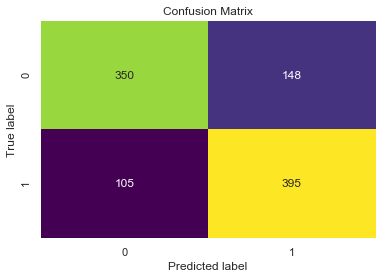

In [28]:
# Fit CNN with Adam optimizer and 200 batches
fit_evaluate_cnn(200)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 294s 59ms/step - loss: 0.5419 - acc: 0.7350 - val_loss: 0.5498 - val_acc: 0.7321
Epoch 2/50
5011/5011 [==============================] - 293s 58ms/step - loss: 0.5414 - acc: 0.7328 - val_loss: 0.5506 - val_acc: 0.7271
Epoch 3/50
5011/5011 [==============================] - 292s 58ms/step - loss: 0.5410 - acc: 0.7342 - val_loss: 0.5504 - val_acc: 0.7311
Epoch 4/50
5011/5011 [==============================] - 295s 59ms/step - loss: 0.5409 - acc: 0.7338 - val_loss: 0.5501 - val_acc: 0.7311
Epoch 5/50
5011/5011 [==============================] - 292s 58ms/step - loss: 0.5413 - acc: 0.7330 - val_loss: 0.5509 - val_acc: 0.7301
Epoch 6/50
5011/5011 [==============================] - 298s 60ms/step - loss: 0.5409 - acc: 0.7342 - val_loss: 0.5505 - val_acc: 0.7311
Epoch 7/50
5011/5011 [==============================] - 293s 58ms/step - loss: 0.5409 - acc: 0.7330 - val_loss: 0.5500 - val_acc: 

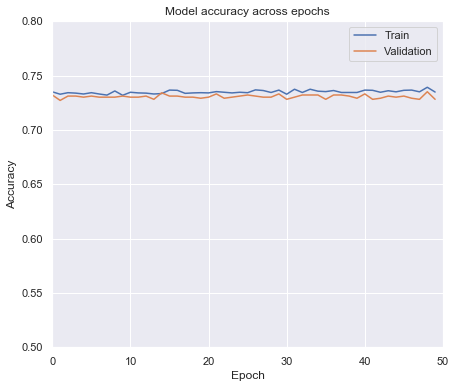

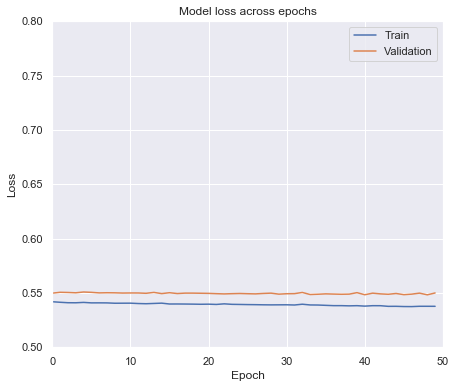

Model performance on the test images
Loss:  0.5431617616651532
Accuracy:  0.751503006012024


Clasification report
             precision    recall  f1-score   support

          0       0.76      0.72      0.74       498
          1       0.74      0.78      0.76       500

avg / total       0.75      0.75      0.75       998



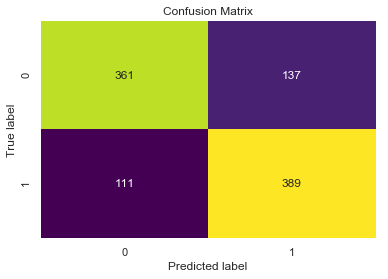

In [29]:
# Fit CNN with Adam optimizer and 400 batches
fit_evaluate_cnn(400)

In [30]:
# End time 
print("Total time to train model: %.2f minutes." % ((time() - start)/60))

Total time to train model: 662.48 minutes.


# 8. Fit the CNN using SGD optimizer at 100, 200 and 400 batch sizes

In [31]:
# Start time
start=time()

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 240s 48ms/step - loss: 0.5382 - acc: 0.7364 - val_loss: 0.5647 - val_acc: 0.7102
Epoch 2/50
5011/5011 [==============================] - 226s 45ms/step - loss: 0.5383 - acc: 0.7360 - val_loss: 0.5503 - val_acc: 0.7371
Epoch 3/50
5011/5011 [==============================] - 223s 45ms/step - loss: 0.5376 - acc: 0.7390 - val_loss: 0.5491 - val_acc: 0.7291
Epoch 4/50
5011/5011 [==============================] - 224s 45ms/step - loss: 0.5383 - acc: 0.7330 - val_loss: 0.5594 - val_acc: 0.7191
Epoch 5/50
5011/5011 [==============================] - 224s 45ms/step - loss: 0.5386 - acc: 0.7400 - val_loss: 0.5560 - val_acc: 0.7211
Epoch 6/50
5011/5011 [==============================] - 225s 45ms/step - loss: 0.5379 - acc: 0.7340 - val_loss: 0.5493 - val_acc: 0.7281
Epoch 7/50
5011/5011 [==============================] - 233s 47ms/step - loss: 0.5382 - acc: 0.7332 - val_loss: 0.5506 - val_acc: 

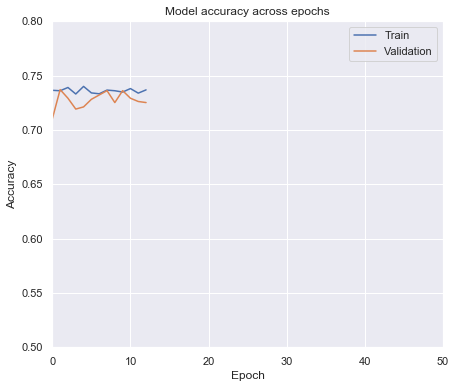

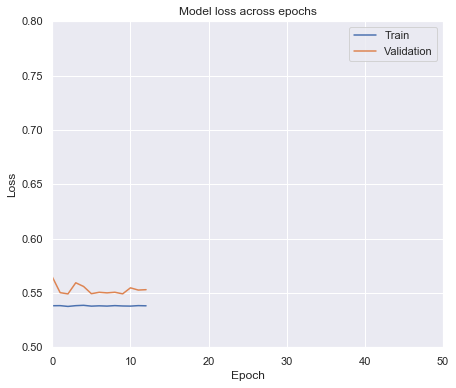

Model performance on the test images
Loss:  0.5445065826237321
Accuracy:  0.754509017916624


Clasification report
             precision    recall  f1-score   support

          0       0.78      0.70      0.74       498
          1       0.73      0.81      0.77       500

avg / total       0.76      0.75      0.75       998



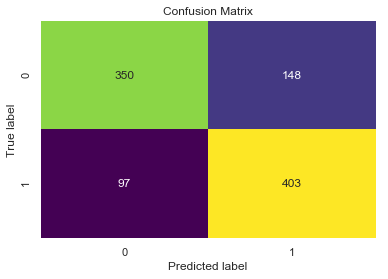

In [32]:
# Fit CNN with SGD optimizer and 100 batches
model.compile(keras.optimizers.SGD(lr=1e-5), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
fit_evaluate_cnn(100)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 219s 44ms/step - loss: 0.5379 - acc: 0.7360 - val_loss: 0.5530 - val_acc: 0.7271
Epoch 2/50
5011/5011 [==============================] - 215s 43ms/step - loss: 0.5375 - acc: 0.7370 - val_loss: 0.5534 - val_acc: 0.7271
Epoch 3/50
5011/5011 [==============================] - 210s 42ms/step - loss: 0.5380 - acc: 0.7360 - val_loss: 0.5496 - val_acc: 0.7261
Epoch 4/50
5011/5011 [==============================] - 210s 42ms/step - loss: 0.5375 - acc: 0.7378 - val_loss: 0.5508 - val_acc: 0.7331
Epoch 5/50
5011/5011 [==============================] - 211s 42ms/step - loss: 0.5375 - acc: 0.7370 - val_loss: 0.5491 - val_acc: 0.7390
Epoch 6/50
5011/5011 [==============================] - 211s 42ms/step - loss: 0.5375 - acc: 0.7376 - val_loss: 0.5579 - val_acc: 0.7201
Epoch 7/50
5011/5011 [==============================] - 210s 42ms/step - loss: 0.5383 - acc: 0.7350 - val_loss: 0.5515 - val_acc: 

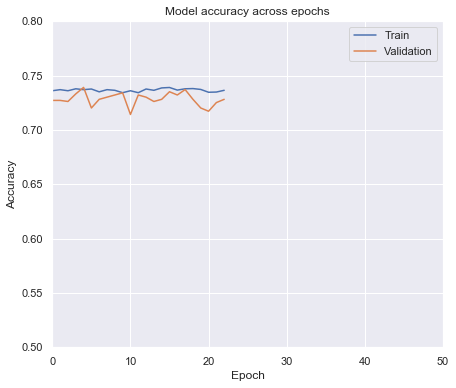

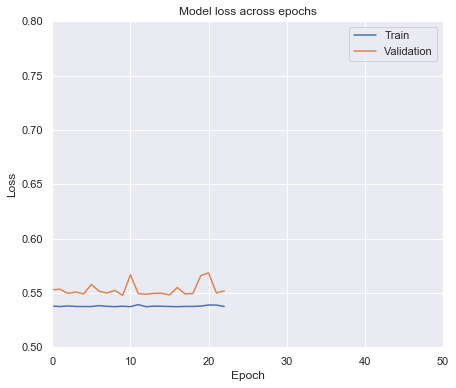

Model performance on the test images
Loss:  0.5438303030086663
Accuracy:  0.7525050100200401


Clasification report
             precision    recall  f1-score   support

          0       0.78      0.71      0.74       498
          1       0.73      0.80      0.76       500

avg / total       0.75      0.75      0.75       998



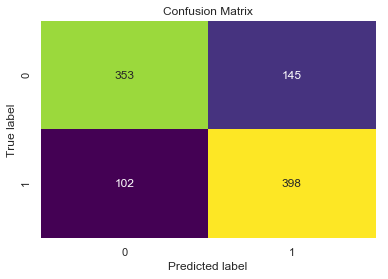

In [33]:
# Fit CNN with SGD optimizer and 200 batches
fit_evaluate_cnn(200)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 259s 52ms/step - loss: 0.5377 - acc: 0.7364 - val_loss: 0.5484 - val_acc: 0.7341
Epoch 2/50
5011/5011 [==============================] - 260s 52ms/step - loss: 0.5372 - acc: 0.7360 - val_loss: 0.5490 - val_acc: 0.7301
Epoch 3/50
5011/5011 [==============================] - 258s 52ms/step - loss: 0.5372 - acc: 0.7372 - val_loss: 0.5486 - val_acc: 0.7321
Epoch 4/50
5011/5011 [==============================] - 262s 52ms/step - loss: 0.5371 - acc: 0.7376 - val_loss: 0.5501 - val_acc: 0.7261
Epoch 5/50
5011/5011 [==============================] - 253s 51ms/step - loss: 0.5372 - acc: 0.7364 - val_loss: 0.5492 - val_acc: 0.7271
Epoch 6/50
5011/5011 [==============================] - 267s 53ms/step - loss: 0.5371 - acc: 0.7400 - val_loss: 0.5486 - val_acc: 0.7321
Epoch 7/50
5011/5011 [==============================] - 256s 51ms/step - loss: 0.5370 - acc: 0.7366 - val_loss: 0.5490 - val_acc: 

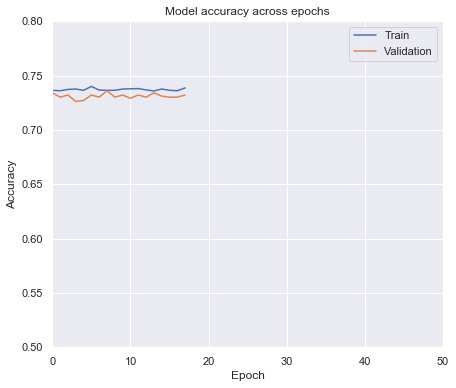

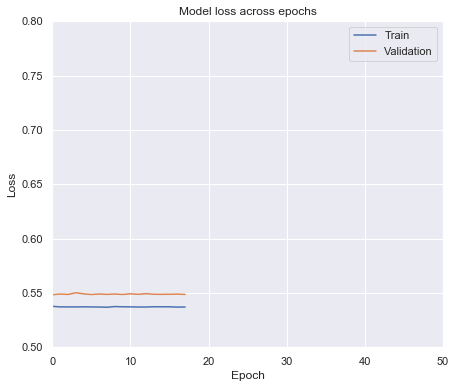

Model performance on the test images
Loss:  0.5437017030610828
Accuracy:  0.7474949898605118


Clasification report
             precision    recall  f1-score   support

          0       0.75      0.74      0.75       498
          1       0.75      0.75      0.75       500

avg / total       0.75      0.75      0.75       998



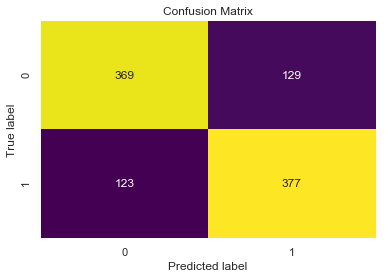

In [34]:
# Fit CNN with SDG optimizer and 400 batches
fit_evaluate_cnn(400)

In [35]:
# End time 
print("Total time to train model: %.2f minutes." % ((time() - start)/60))

Total time to train model: 210.61 minutes.


# 9. Fit the CNN using RMSprop optimizer at 100, 200 and 400 batch sizes

In [36]:
# Start time
start=time()

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 250s 50ms/step - loss: 0.5392 - acc: 0.7332 - val_loss: 0.5481 - val_acc: 0.7380
Epoch 2/50
5011/5011 [==============================] - 244s 49ms/step - loss: 0.5382 - acc: 0.7328 - val_loss: 0.5487 - val_acc: 0.7380
Epoch 3/50
5011/5011 [==============================] - 244s 49ms/step - loss: 0.5383 - acc: 0.7370 - val_loss: 0.5492 - val_acc: 0.7291
Epoch 4/50
5011/5011 [==============================] - 243s 49ms/step - loss: 0.5385 - acc: 0.7376 - val_loss: 0.5473 - val_acc: 0.7331
Epoch 5/50
5011/5011 [==============================] - 244s 49ms/step - loss: 0.5377 - acc: 0.7386 - val_loss: 0.5480 - val_acc: 0.7351
Epoch 6/50
5011/5011 [==============================] - 244s 49ms/step - loss: 0.5374 - acc: 0.7378 - val_loss: 0.5506 - val_acc: 0.7331
Epoch 7/50
5011/5011 [==============================] - 244s 49ms/step - loss: 0.5369 - acc: 0.7358 - val_loss: 0.5524 - val_acc: 

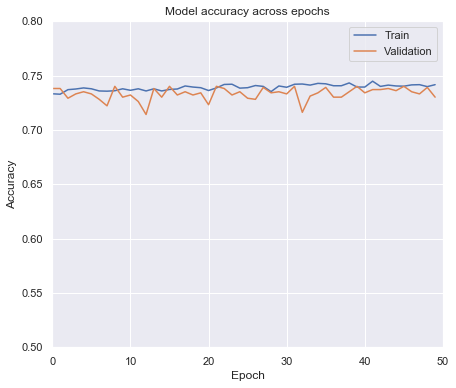

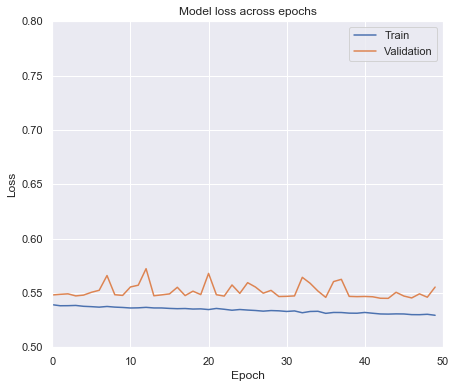

Model performance on the test images
Loss:  0.5441450838574426
Accuracy:  0.7454909818444797


Clasification report
             precision    recall  f1-score   support

          0       0.79      0.67      0.72       498
          1       0.71      0.82      0.76       500

avg / total       0.75      0.75      0.74       998



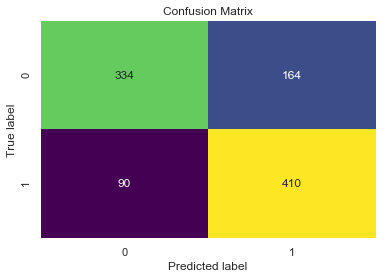

In [37]:
# Fit CNN with RMSprop optimizer and 100 batches
model.compile(keras.optimizers.RMSprop(lr=1e-5), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
fit_evaluate_cnn(100)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 223s 45ms/step - loss: 0.5286 - acc: 0.7412 - val_loss: 0.5627 - val_acc: 0.7241
Epoch 2/50
5011/5011 [==============================] - 220s 44ms/step - loss: 0.5297 - acc: 0.7410 - val_loss: 0.5537 - val_acc: 0.7321
Epoch 3/50
5011/5011 [==============================] - 220s 44ms/step - loss: 0.5286 - acc: 0.7414 - val_loss: 0.5584 - val_acc: 0.7281
Epoch 4/50
5011/5011 [==============================] - 220s 44ms/step - loss: 0.5288 - acc: 0.7430 - val_loss: 0.5557 - val_acc: 0.7301
Epoch 5/50
5011/5011 [==============================] - 220s 44ms/step - loss: 0.5291 - acc: 0.7456 - val_loss: 0.5451 - val_acc: 0.7351
Epoch 6/50
5011/5011 [==============================] - 220s 44ms/step - loss: 0.5289 - acc: 0.7418 - val_loss: 0.5596 - val_acc: 0.7301
Epoch 7/50
5011/5011 [==============================] - 221s 44ms/step - loss: 0.5282 - acc: 0.7436 - val_loss: 0.5662 - val_acc: 

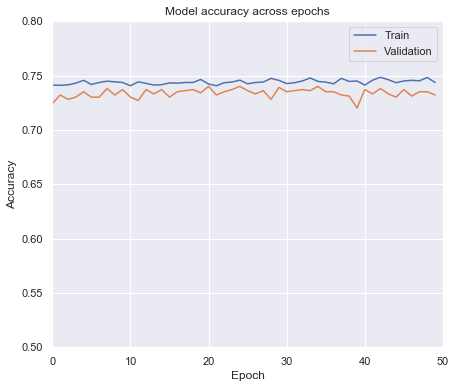

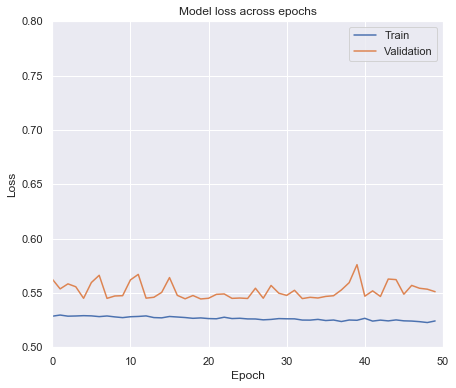

Model performance on the test images
Loss:  0.5506505255469817
Accuracy:  0.7434869739478958


Clasification report
             precision    recall  f1-score   support

          0       0.71      0.81      0.76       498
          1       0.78      0.67      0.72       500

avg / total       0.75      0.74      0.74       998



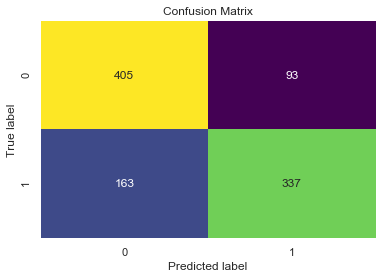

In [38]:
# Fit CNN with RMSprop optimizer and 200 batches
fit_evaluate_cnn(200)

Train on 5011 samples, validate on 1004 samples
Epoch 1/50
5011/5011 [==============================] - 257s 51ms/step - loss: 0.5241 - acc: 0.7454 - val_loss: 0.5453 - val_acc: 0.7361
Epoch 2/50
5011/5011 [==============================] - 258s 52ms/step - loss: 0.5220 - acc: 0.7478 - val_loss: 0.5489 - val_acc: 0.7380
Epoch 3/50
5011/5011 [==============================] - 263s 53ms/step - loss: 0.5236 - acc: 0.7460 - val_loss: 0.5442 - val_acc: 0.7371
Epoch 4/50
5011/5011 [==============================] - 262s 52ms/step - loss: 0.5226 - acc: 0.7488 - val_loss: 0.5443 - val_acc: 0.7361
Epoch 5/50
5011/5011 [==============================] - 268s 54ms/step - loss: 0.5228 - acc: 0.7468 - val_loss: 0.5464 - val_acc: 0.7351
Epoch 6/50
5011/5011 [==============================] - 258s 52ms/step - loss: 0.5229 - acc: 0.7472 - val_loss: 0.5515 - val_acc: 0.7351
Epoch 7/50
5011/5011 [==============================] - 261s 52ms/step - loss: 0.5219 - acc: 0.7458 - val_loss: 0.5457 - val_acc: 

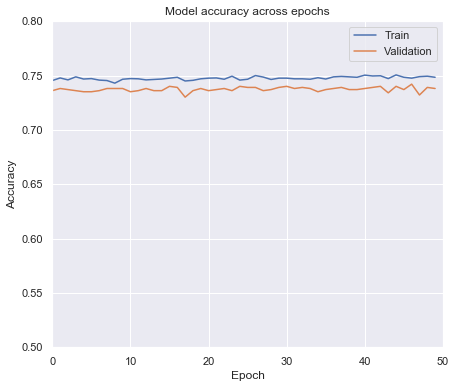

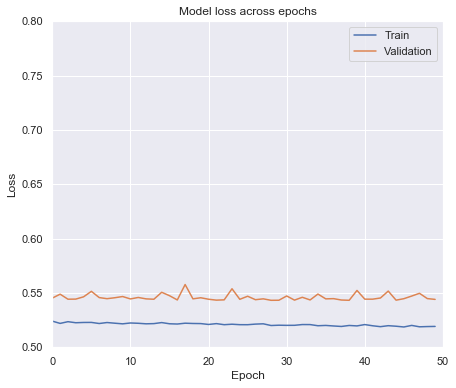

Model performance on the test images
Loss:  0.5364087748384189
Accuracy:  0.7454909819639278


Clasification report
             precision    recall  f1-score   support

          0       0.76      0.72      0.74       498
          1       0.73      0.77      0.75       500

avg / total       0.75      0.75      0.75       998



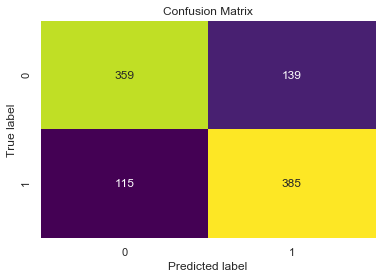

In [39]:
# Fit CNN with RMSprop optimizer and 400 batches
fit_evaluate_cnn(400)

In [40]:
# End time 
print("Total time to train model: %.2f minutes." % ((time() - start)/60))

Total time to train model: 609.23 minutes.


# 10. Fit the CNN using Adam optimzer, 200 batch size and feature-wise centered and normalized images 

In [41]:
# Compile the model
model.compile(keras.optimizers.Adam(lr=1e-5), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [42]:
# Data generator
feat_norm = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

In [44]:
# Train, validation and test image generators
train_feat_norm=feat_norm.flow(x_train, y_trainCat, batch_size=200)
valid_prep=keras.preprocessing.image.ImageDataGenerator().flow(x_valid, y_validCat, batch_size=200)
test_prep=keras.preprocessing.image.ImageDataGenerator().flow(x_test, y_testCat, batch_size=200)

In [45]:
adam_feat_norm=model.fit_generator(train_feat_norm, steps_per_epoch=len(x_train) / 100, epochs=50, 
                                   validation_data=valid_prep,validation_steps=5, verbose=2,
                                   callbacks=[early_stopping, reduce_lr] )

Epoch 1/50
 - 501s - loss: 0.5212 - acc: 0.7447 - val_loss: 0.5433 - val_acc: 0.7390
Epoch 2/50
 - 489s - loss: 0.5256 - acc: 0.7422 - val_loss: 0.5376 - val_acc: 0.7500
Epoch 3/50
 - 459s - loss: 0.5142 - acc: 0.7513 - val_loss: 0.5426 - val_acc: 0.7363
Epoch 4/50
 - 454s - loss: 0.5184 - acc: 0.7455 - val_loss: 0.5752 - val_acc: 0.7301
Epoch 5/50
 - 457s - loss: 0.5292 - acc: 0.7423 - val_loss: 0.5336 - val_acc: 0.7525
Epoch 6/50
 - 466s - loss: 0.5077 - acc: 0.7575 - val_loss: 0.5299 - val_acc: 0.7413
Epoch 7/50
 - 457s - loss: 0.5264 - acc: 0.7400 - val_loss: 0.5462 - val_acc: 0.7450
Epoch 8/50
 - 458s - loss: 0.5190 - acc: 0.7463 - val_loss: 0.5494 - val_acc: 0.7313
Epoch 9/50
 - 455s - loss: 0.5256 - acc: 0.7433 - val_loss: 0.5243 - val_acc: 0.7649
Epoch 10/50
 - 456s - loss: 0.5172 - acc: 0.7496 - val_loss: 0.5623 - val_acc: 0.7177
Epoch 11/50
 - 461s - loss: 0.5104 - acc: 0.7515 - val_loss: 0.5281 - val_acc: 0.7512
Epoch 12/50
 - 458s - loss: 0.5085 - acc: 0.7551 - val_loss: 0.

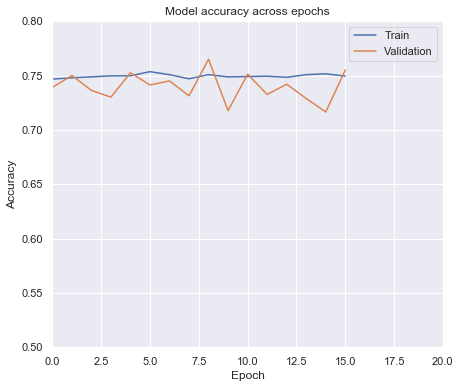

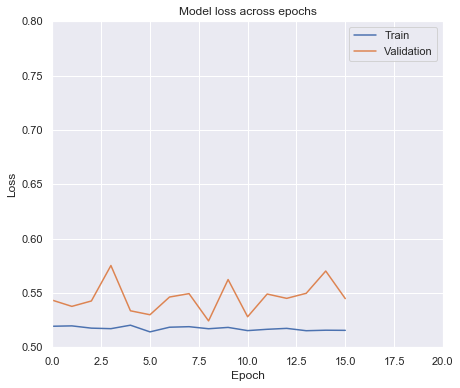

In [47]:
#Plot accuracy
sns.set(style="darkgrid")
fig = plt.figure(figsize=(7,6))
plt.plot(adam_feat_norm.history['acc']) # Train accuracy
plt.plot(adam_feat_norm.history['val_acc']) # Validation accuracy
plt.title('Model accuracy across epochs')
plt.ylim(0.5, 0.8)
plt.xlim(0, 20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()
    
# Plot loss
sns.set(style="darkgrid")
fig = plt.figure(figsize=(7,6))
plt.plot(adam_feat_norm.history['loss']) # Train loss 
plt.plot(adam_feat_norm.history['val_loss']) # Validation loss
plt.title('Model loss across epochs')
plt.ylim(0.5, 0.8)
plt.xlim(0, 20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [49]:
print('Model performance on the test images')
    
# Make a prediction on the test set
test_score = model.evaluate_generator(test_prep, steps=5, verbose=0)
    
# Accuracy and loss on the test samples 
print('Loss: ', test_score[0])
print('Accuracy: ', test_score[1])
print('\n')

Model performance on the test images
Loss:  0.5294877236974024
Accuracy:  0.7545090176777276




# 11. Evalute the CNN using pre-trained VGG16 model weights

In [50]:
# VGG16
vgg16 = keras.applications.vgg16.VGG16(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

# Add top layer
x = vgg16.output
x = Flatten()(x)
pred_layer = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg16.input, outputs=pred_layer)

# Make layers non-trainable
for layer in vgg16.layers:
    layer.trainable = False
        
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
    
# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [51]:
# Start time
start=time()

In [53]:
# Fit the model
vgg16_history = model.fit(x_train,y_trainCat, epochs=20, batch_size=100, validation_data=(x_valid,y_validCat), 
                          verbose=1, callbacks=[early_stopping, reduce_lr])

Train on 5011 samples, validate on 1004 samples
Epoch 1/20
5011/5011 [==============================] - 1691s 338ms/step - loss: 0.7088 - acc: 0.5053 - val_loss: 0.6953 - val_acc: 0.4801
Epoch 2/20
5011/5011 [==============================] - 1677s 335ms/step - loss: 0.6933 - acc: 0.4957 - val_loss: 0.6934 - val_acc: 0.4801
Epoch 3/20
5011/5011 [==============================] - 1639s 327ms/step - loss: 0.6932 - acc: 0.5053 - val_loss: 0.6937 - val_acc: 0.4801
Epoch 4/20
5011/5011 [==============================] - 1629s 325ms/step - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6939 - val_acc: 0.4801
Epoch 5/20
5011/5011 [==============================] - 1617s 323ms/step - loss: 0.6934 - acc: 0.5053 - val_loss: 0.6945 - val_acc: 0.4801
Epoch 6/20
5011/5011 [==============================] - 1618s 323ms/step - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6937 - val_acc: 0.4801
Epoch 7/20
5011/5011 [==============================] - 1617s 323ms/step - loss: 0.6933 - acc: 0.5053 - val_loss: 0.69

In [54]:
# End time 
print("Total time to train model: %.2f minutes." % ((time() - start)/60))

Total time to train model: 550.66 minutes.


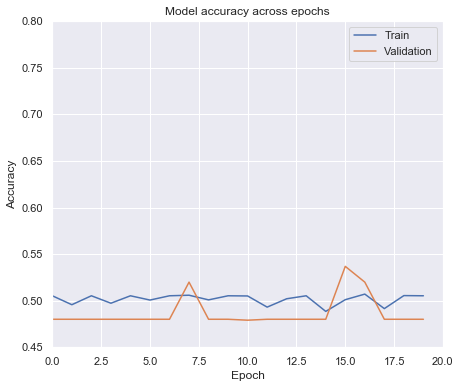

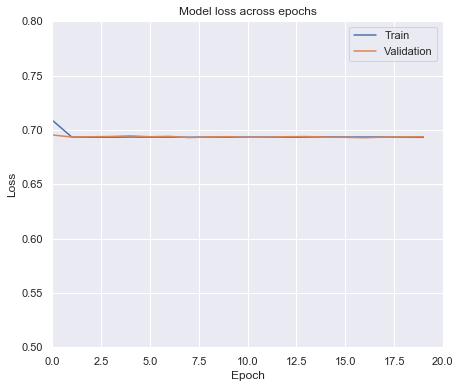

In [56]:
#Plot accuracy
sns.set(style="darkgrid")
fig = plt.figure(figsize=(7,6))
plt.plot(vgg16_history.history['acc']) # Train accuracy
plt.plot(vgg16_history.history['val_acc']) # Validation accuracy
plt.title('Model accuracy across epochs')
plt.ylim(0.45, 0.8)
plt.xlim(0, 20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()
    
# Plot loss
sns.set(style="darkgrid")
fig = plt.figure(figsize=(7,6))
plt.plot(vgg16_history.history['loss']) # Train loss 
plt.plot(vgg16_history.history['val_loss']) # Validation loss
plt.title('Model loss across epochs')
plt.ylim(0.5, 0.8)
plt.xlim(0, 20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Model performance on the test images
Loss:  0.6931653176854273
Accuracy:  0.5010020041274642


Clasification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       498
          1       0.50      1.00      0.67       500

avg / total       0.25      0.50      0.33       998



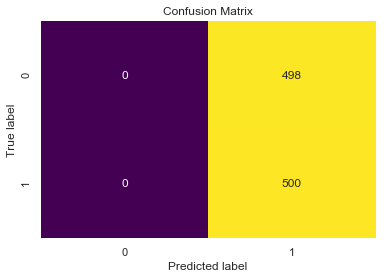

In [57]:
print('Model performance on the test images')
    
# Make predictions on the test images
test_score = model.evaluate(x_test, y_testCat, verbose=0)
    
# Accuracy and loss on the test samples 
print('Loss: ', test_score[0])
print('Accuracy: ', test_score[1])
print('\n')
    
# Classification report
test_pred=model.predict(x_test)
test_pred=np.round(test_pred)
print('Clasification report')
print(classification_report(y_testCat, test_pred))
    
# Predictions on the test images
prediction = model.predict(x_test, verbose=0)
    
# Collect prediction on a list
y_pred = []
    
# Append the index of the larger value to the list
for i in prediction:
    y_pred.append(list(i).index(max(i)))
    
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Next steps**

Even though this realtively simple CNN model achieved reasonable performance, I would like to explore the following options to further improve the model. More specifically, I would like to:

* use more images of the original size (1024x1024x3) for training to improve accuracy.

* add few convolutional and pooling layers as well as batch normalization and drop some layers to avoid overfitting and to improve the CNN architecture.

* use few other image pre-processing techniques such as flipping images horizontally or vertically, rotating, transforming images such as affine transformation, etc to explore whether those techniques improve accuracy.

* explore more pre-trained models for this classification task. 